Note to graders: I generated a 1000 molecule subset of the data to use for the tSNE visualization and for hierarchical clustering. It was generated by choosing random molecules without replacement. The code to generate the subset indices is in my Q2 code.

Also, some of the cells have redundant code (ex: loading the same modules or same data in multiple cells). This is intentional. I did not run all the cells at once so sometimes I had to reload modules or data.

### Question 1
I implemented two different distance metrics: jaccard distance and euclidean distance. Jaccard distance = 1 - (intersection of on bits / union of on bits). Euclidean distance is the length of the line connecting two points. Here, we can imagine the dense representation of on bits as the coordinates for 1024 dimensions. Euclidean distance = square root of the sum of the squared dimensional distances. For my clustering implementations, the default distance metric for hierarchical clustering is jaccard distance and the default distance metric for partition clustering is euclidean distance.

I chose jaccard distance for hierarchical clustering because:
(1) Jaccard distance is faster than many other distance metrics which is important because hierarchical clustering is relatively slower than many other clustering approaches so this helps speed the clustering up.
(2) Jaccard distance makes a lot of biological sense for the ligand data, since it's essentially computing the fraction of shared substructures between the molecules.

I chose euclidean distance for partition clustering because:
(1) I implemented kmeans for my partition clustering, which involves centroids. To me, the most mathematically logical way to compute centroids was to find arithmetic means of the coordinates of the points in the clusters. Given this approach, the centroids could have coordinates ranging from 0 to 1, instead of a binary 0 or 1. Jaccard distance would not work on this, but euclidean distance does.
(2) Kmeans is faster than many other clustering algorithms. Also, I implemented kmeans++ initialization, which speeds it up even further. Given this, I felt like I could afford the extra time that computing euclidean distance takes compared to jaccard distance.

In summary, I chose jaccard distance for hierarchical clustering because it made biological sense and is fast, and I chose euclidean distance for partition clustering because it made mathematical sense and kmeans can take the "hit" on speed.

### Question 2
Out of curiosity, I decided to try out both PCA and tSNE. I ran PCA on all of the molecules, and I ran tSNE on the 1000 molecule subset. For subsequent visualizations, I include results for both PCA and tSNE because I think it gives a more comprehensive picture than just using one of them.

In [24]:
from clusters import algs
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get dense representation of bits
lig_coords = np.array([l.bit_string for l in ligs])

# Pre-process data
sc = StandardScaler()
lc_pp = sc.fit_transform(lig_coords)

# Do PCA
pca = PCA(n_components=2)
lc_pca = pca.fit_transform(lc_pp)

# Save pca values for future reference
np.save("part2_results_data/q2-pca_vals.npy", np.asarray(lc_pca))

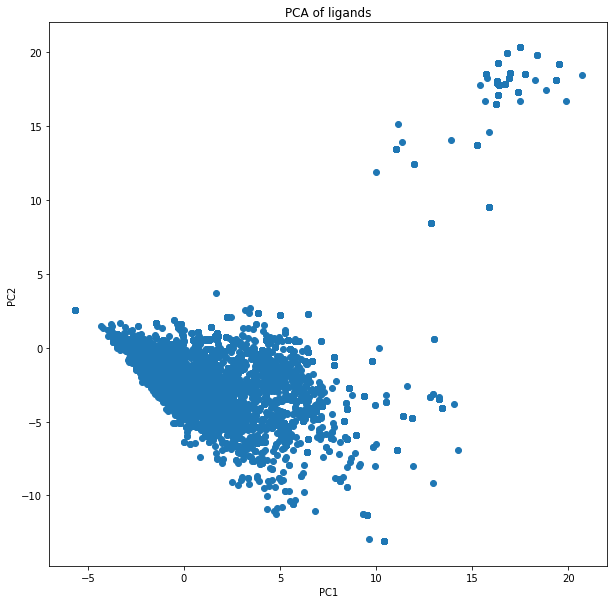

In [25]:
import matplotlib.pyplot as plt

# Plot PCA results
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(lc_pca[:,0], lc_pca[:,1])
plt.title("PCA of ligands")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("part2_plots/q2-pca.png")

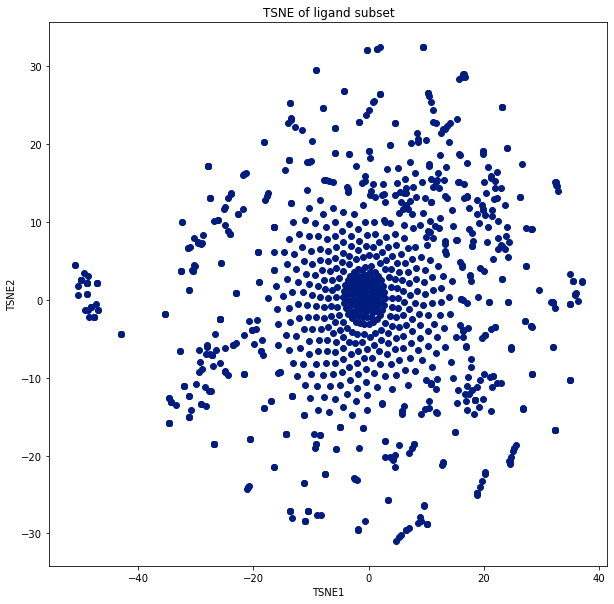

In [94]:
from clusters import algs
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get dense representation of bits
lig_coords = np.array([l.bit_string for l in ligs])

# Get subset
subset_idx = np.random.choice(len(lig_coords), size=1000, replace=False)
sub_idx = np.sort(subset_idx)
lig_subset = lig_coords[sub_idx,:]

# Save subset indices for future reference
np.save("part2_results_data/sub_idx.npy", sub_idx)

# Do TSNE
tsne = TSNE()
lc_tsne = tsne.fit_transform(lig_subset)

# Save tsne values for future reference
np.save("part2_results_data/q2-tsne_vals.npy", np.asarray(lc_tsne))

# Plot TSNE results
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(lc_tsne[:,0], lc_tsne[:,1])
plt.title("TSNE of ligand subset")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.savefig("part2_plots/q2-tsne.png")

Interestingly, the plots look pretty different although I guess that's not super surprising since they are different dimensionality reduction algorithms. Both of them seem to have one really big cluster and one small cluster.

### Question 3

In [11]:
from clusters import algs
import numpy as np

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")
lig_coords = np.array([l.bit_string for l in ligs])

# Evaluate number of clusters
k_scores = {}
for k in range(2,11):
    pck = algs.PartitionClustering(k)
    ck = pck.cluster(lig_coords)
    s = algs.compute_silhouette_score(ck, lig_coords)
    k_scores[k] = s
print(k_scores)

# Save results
np.save("part2_results_data/q3-kscores.npy", np.asarray(list(k_scores.items())))

{2: 0.11931603541037976, 3: 0.35235852718321137, 4: 0.3518311234088012, 5: 0.36090025292274874, 6: 0.32974020031255097, 7: 0.38072777841271555, 8: 0.3605417802619046, 9: 0.3705720428627395, 10: 0.38529953960441404}


In [11]:
# k=10 had the highest silhouette score so I will forge ahead with that

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")
lig_coords = np.array([l.bit_string for l in ligs])

# Do partition clustering
p = algs.PartitionClustering(10)
cp = p.cluster(lig_coords)

# Save clusters
np.save("part2_results_data/q3-clusters.npy", cp)

In [74]:
# Confirm there are 10 clusters
len(cp)

10

In [25]:
# Load pca values
pca_vals = np.load("part2_results_data/q2-pca_vals.npy")

# Get cluster assignments
cpa = algs.get_cluster_assignments(cp)
cpa_array = np.asarray([cpa[i] for i in range(len(cpa))])

# Make array with both
pca_and_cpa = np.hstack((pca_vals, cpa_array[:,None]))

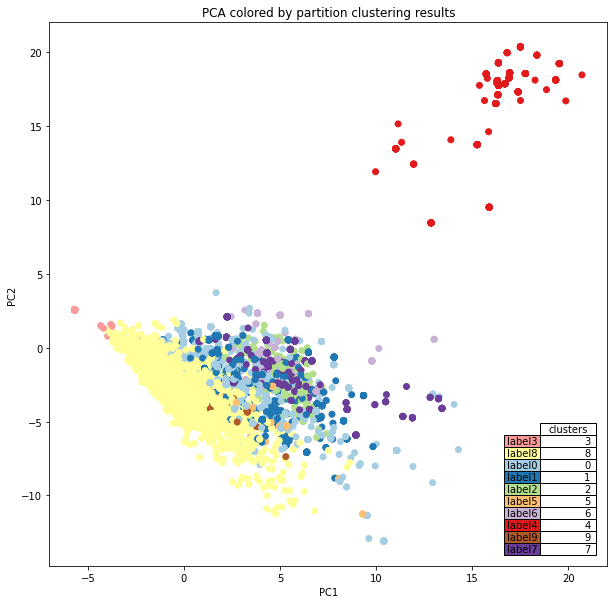

In [101]:
# Reference for legend/table in this plotting function:
# https://stackoverflow.com/questions/42056713/matplotlib-scatterplot-with-legend

# Note to grader: I know that the legend/table is not in numerically increasing
# order, but I spent a long time trying to get a legend/table that actually appears
# on the plot and accurately maps to the correct cluster. The row order here is a
# bit unusual, but it is functional and accurate.

# Plot PCA colored by partition clustering results
a = pca_and_cpa[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 10)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(pca_and_cpa[:,0], pca_and_cpa[:,1], c=pca_and_cpa[:,2], cmap=cmap)
plt.title("PCA colored by partition clustering results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q3-pca.png")

In [27]:
# Load tsne values
tsne_vals = np.load("part2_results_data/q2-tsne_vals.npy")

# Get cluster assignments for subset
sub_idx = np.load("part2_results_data/sub_idx.npy")
cpa_sub_array = cpa_array[sub_idx]

# Make array with both
tsne_and_cpa = np.hstack((tsne_vals, cpa_sub_array[:,None]))

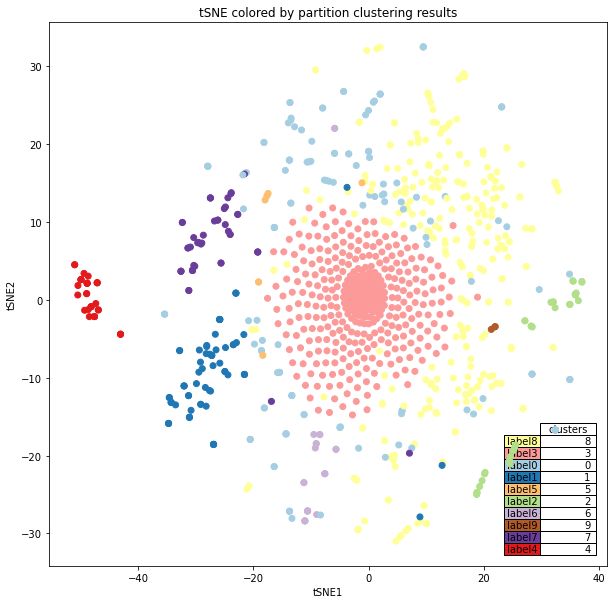

In [100]:
# Plot tSNE colored by partition clustering results
a = tsne_and_cpa[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 10)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(tsne_and_cpa[:,0], tsne_and_cpa[:,1], c=tsne_and_cpa[:,2], cmap=cmap)
plt.title("tSNE colored by partition clustering results")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q3-tsne.png")

In [97]:
# Note: the pca visualization includes all the data and the tsne visualization
# just includes the subset. Consequently, all 10 clusters are represented in
# the pca visualization but 9/10 are represented for tsne visualization

print("Num clusters represented in pca viz: ", str(len(set(pca_and_cpa[:,2]))))
print("Num clusters represented in tsne viz: ", str(len(set(tsne_and_cpa[:,2]))))

Num clusters represented in pca viz:  10
Num clusters represented in tsne viz:  9


### Question 4

For my partition clustering algorithm, I chose to implement kmeans with kmeans++ initialization. For centroid initialization, this entails picking the first centroid randomly and then picking subsequent centroids with probability proportional to their distance to already chosen centroids. This makes it so the initial centroids are more likely to be spread out, which can make kmeans converge faster and produce better clusters. It reduces the chances that there are very clusters competeting for points. This initialization approach is important because kmeans is non-deterministic. Running it several times on the same data will not necessarily yield the same clusters. So like many things in life, a good starting point can be helpful for getting to a good ending point.

For reasons described in question 1, the default distance function  for my partitioning algorithm is euclidean distance. I think the clustering algorithm would be sensitive to the distance metric choice because different metrics scale differently on high dimensional data, and in some cases, the distance metric choice impacts how centroids can be computed. For example, if the selected distance metric was jaccard distance, the centroids' coordinates would all have to be binary. I think the clustering results would be sensitive to that.

For my API, the main initialization conditions are the number of clusters (k) and the maximum number of iterations. As demonstrated by the output of the first cell in question 3, the clustering is sensitive to this. I calculated silhouette score for k=2,...,10 and the scores ranged from 0.12 to 0.39. The score was highest (0.39) for k=10 so I selected 10 as my number of clusters for partition clustering.

The score for k=2 was fairly low (0.12), but all of the scores for the other values of k were similar to each other (ranging from 0.33 to 0.39). To me, this suggests that while k=10 might be optimal, any value between 3 and 10 would have been reasonable.

The max iterations is useful if the clustering is not reaching convergence (ie a point is hopping back and forth between 2 nearby clusters). If the number of iterations reaches the specified max, then the clustering algorithm is terminated and the current clustering is returned. I set the default max as 100. Given a relatively high max in conjunction with the wonderfulness of kmeans++ initialization, it seems unlikely that drastically sub-optimal clusterings would be produced if the max is reached. If the max iteration was quite low (say, 5 or something), I think the clustering results could be pretty sensitive to that. Although kmeans++ initialization is dandy, it is a somewhat stochastic process so it's possible that an initialization would not be great and a high number of iterations would be required to reach a good clustering. In that case, with a very low max iteration, the good clustering might not be reached. So I think the clustering could be sensitive to the max iteration initialization parameter.

### Question 5

In [1]:
from clusters import algs
import numpy as np

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get subset for hierarchical clustering
sub_idx = np.load("part2_results_data/sub_idx.npy")
lig_sub_coords = np.array([l.bit_string for l in ligs[sub_idx]])

# Evaluate number of clusters
k_scoresH = {}
for k in range(2,11):
    hck = algs.HierarchicalClustering(k)
    ck = hck.cluster(lig_sub_coords)
    s = algs.compute_silhouette_score(ck, lig_sub_coords)
    k_scoresH[k] = s
print(k_scoresH)

# Save results
np.save("part2_results_data/q5-kscores.npy", np.asarray(list(k_scoresH.items())))

{2: 0.15702337713310321, 3: 0.15022832886753007, 4: 0.1493658333002135, 5: 0.3875037068404428, 6: 0.37484976465891073, 7: 0.3662563828196964, 8: 0.3657252580668898, 9: 0.3636467203024084, 10: 0.3618902755929432}


In [10]:
# k=5 had the highest silhouette score so I will forge ahead with that

# Load ligands
ligs = algs.load_ligands("ligand_information.csv")

# Get subset for hierarchical clustering
sub_idx = np.load("part2_results_data/sub_idx.npy")
lig_sub_coords = np.array([l.bit_string for l in ligs[sub_idx]])

# Do hierarchical clustering
h = algs.HierarchicalClustering(5)
ch = h.cluster(lig_sub_coords)

# Save clusters
np.save("part2_results_data/q5-clusters.npy", ch)

In [3]:
# Confirm there are 5 clusters
len(ch)

5

In [31]:
# Load pca values
pca_vals = np.load("part2_results_data/q2-pca_vals.npy")

# Get cluster assignments
cha = algs.get_cluster_assignments(ch)
cha_array = np.asarray([cha[i] for i in range(len(cha))])

# Get subset of pca results
pca_sub_vals = pca_vals[sub_idx]

# Make array with both
pca_and_cha = np.hstack((pca_sub_vals, cha_array[:,None]))

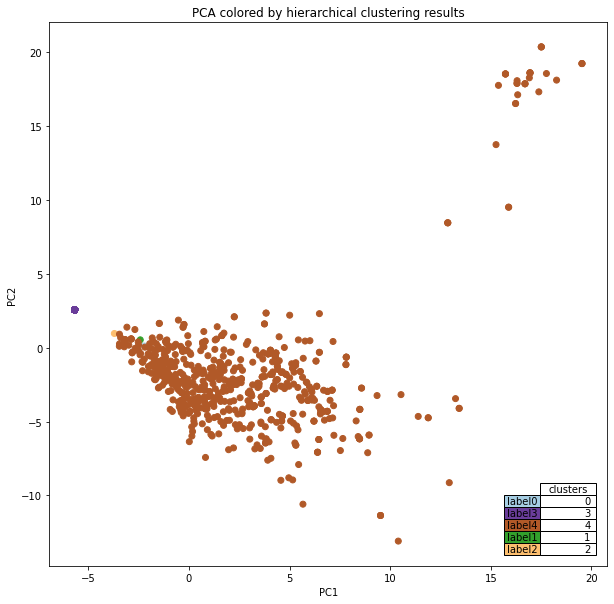

In [98]:
import matplotlib.pyplot as plt

# Plot PCA colored by hierarchical clustering results
a = pca_and_cha[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 5)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(pca_and_cha[:,0], pca_and_cha[:,1], c=pca_and_cha[:,2], cmap=cmap)
plt.title("PCA colored by hierarchical clustering results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q5-pca.png")

The other clusters are somewhat obscured by the big brown cluster, but they do exist. Cell 3 of this question confirms there are 5 clusters and you can see most of them peeking out of the big brown blob.

In [7]:
# Load tsne values
tsne_vals = np.load("part2_results_data/q2-tsne_vals.npy")

# Make array with both
tsne_and_cha = np.hstack((tsne_vals, cha_array[:,None]))

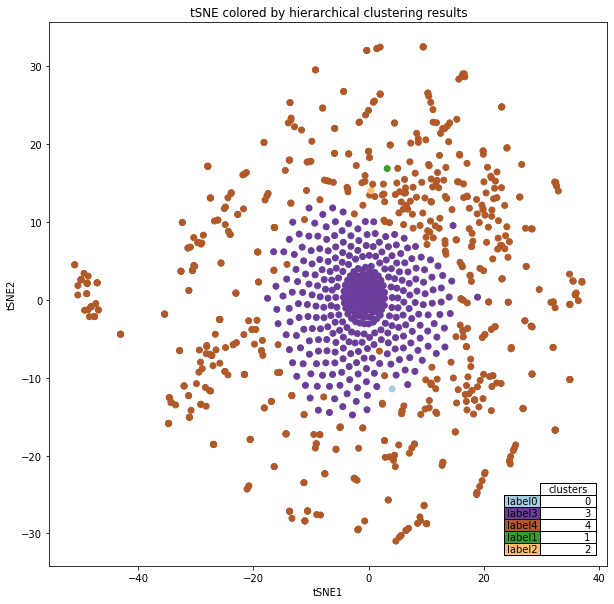

In [99]:
# Plot tSNE colored by hierarchical clustering results
a = tsne_and_cha[:,2]
unique_classes=[int(a[i]) for i in sorted(np.unique(a, return_index=True)[1])]
cmap = plt.cm.get_cmap("Paired", 5)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(tsne_and_cha[:,0], tsne_and_cha[:,1], c=tsne_and_cha[:,2], cmap=cmap)
plt.title("tSNE colored by hierarchical clustering results")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.table(cellText=[[x] for x in unique_classes], loc='lower right',
          colWidths=[0.1],
          rowColours=cmap(np.array(unique_classes)),
          rowLabels=['label%d'%x for x in unique_classes],
          colLabels=['clusters'])
plt.savefig("part2_plots/q5-tsne.png")

### Question 6

For the hierarchical clustering analysis in this notebook, it is based on a randomly selected (without replacement) 1000-sized subset of the ligand data.

For my hierarchical clustering algorithm, I implemented an agglomerative approach to forming clusters. First, each point is assigned to its own cluster, and then clusters are iteratively combined based on their distances to each other. The linkage method I chose was single linkage. Single linkage means that the distance between two clusters is computed as the distance between the two closest points from each respective cluster. This method works well when clusters are not super separate, spherical, or compact. As illustrated in the dimensionality reduction plots, this data is fairly diffuse and don't necessarily form many isolated spherical clusters.

For reasons described in question 1, the default distance function for my hierarchical algorithm is jaccard distance. I think the clustering would be pretty sensitive to the choice of distance metric because the entire hierarchical clustering process is based on the initial distance matrix. If the distance metric were different, the distance matrix would also be different, and then different clusters would get combined at different times to form different agglomerates.

For my API, the main initialization condition is the number of clusters (k). As demonstrated by the output of the first cell in question 5, the clustering is sensitive to this. I calculated silhouette score for k=2,...,10 and the scores ranged from 0.15 to 0.39. The score was highest (0.39) for k=5 so I selected 5 as my number of clusters for hierarchical clustering.

The scores for k=2,3,4 were fairly low (0.15-0.16), but all of the scores for the other values of k were similar to each other (ranging from 0.36 to 0.39). To me, this suggests that while k=5 might be optimal, any value between 5 and 10 would have been reasonable.

### Question 7

In [13]:
from clusters import algs

# Evaluate both clusterings using silhouette score

# Out of curiosity, compute silhouette score using both jaccard distance
# and euclidean distance

# Partition clustering
pc_sil_jac = algs.compute_silhouette_score(cp, lig_coords, dist_fun=algs.calc_jaccard_distance)
print(pc_sil_jac)
pc_sil_euc = algs.compute_silhouette_score(cp, lig_coords, dist_fun=algs.calc_euclidean_distance)
print(pc_sil_euc)

# Hierarchical clustering
hc_sil_jac = algs.compute_silhouette_score(ch, lig_sub_coords, dist_fun=algs.calc_jaccard_distance)
print(hc_sil_jac)
hc_sil_euc = algs.compute_silhouette_score(ch, lig_sub_coords, dist_fun=algs.calc_euclidean_distance)
print(hc_sil_euc)

0.38406790462373086
0.2839877287178786
0.3875037068404428
0.22071741644274478


For quality metric, I chose to implement silhouette score. Silhouette score is a measurement of the comparison between the intra-cluster distance and inter-cluster distance. To calculate a silhouette score for a clustering, calculate silhouette scores for each point and then take the mean. To calculate a silhouette score for a point, compute its cohesion (distance to other points in the same cluster), compute its separation (distance to other points in the nearest cluster), and then take the difference and divide by the max of the two. When computing separation, the nearest cluster to a point is defined as the cluster whose mean distance to each point is the lowest.

In the above cell, I computed the silhouette score for the clusterings resulting from partition clustering and from hierarchical clustering. For each one, I compueted the silhouette score using a distance metric of jaccard distance and using a distance metric of euclidean distance. For jaccard, hierarchical clustering had a slightly higher silhouette score (0.39 vs 0.38). For euclidean, partition clustering had a higher silhouette score (0.28 vs 0.22).

I calculated the silhouette score using both distance metrics because I was curious if the distance metric choice would change the result. This is in part due to the fact that the partition clustering was implemented with euclidean distance and the hierarchical clustering was implemented with jaccard distance. Given this, it is perhaps unsurprising that partition clustering had a higher silhouette score when euclidean distance was used and hierarchical clustering had a higher silhouette score when jaccard distance was used.

With that said, I think the partition clustering performed "best", both because of the wider difference in euclidean-based score than jaccard-based score and because visually, the clustering visualized in question 3 seems a lot more sensible and useful than the clustering visualized in question 5. In the plots in question 5, it looks like 2 clusters really dominate, whereas in the plots in question 3, there are several well-populated clusters. This seems more biologically useful.

### Question 8

In [21]:
# Create mapping between subset ids and subset indices
sub_map = {idx: id for id, idx in enumerate(sub_idx)}

# For clusters in partition clustering, get cluster members that are in subset
# and map ids to indices
cp_sub = np.array([algs.Cluster() for j in range(len(cp))])
for j in range(len(cp)):
    mems = []
    for m in cp[j].members:
        if m in sub_idx:
            mems.append(sub_map[m])
        cp_sub[j].members = np.array(mems)

In [22]:
# Compare clusterings
ji = algs.compute_jaccard_index(cp_sub, ch)
print(ji)

0.4374509015670929


In [23]:
# Out of curiosity, also do partition clustering on subset and compute jaccard index
cps = p.cluster(lig_sub_coords)
jis = algs.compute_jaccard_index(cps, ch)
print(jis)

0.5332851873823219


For similarity metric, I chose to implement jaccard index. Jaccard index is the number of pairs that were clustered in the same cluster in both clusterings divided by the sum of the following: the number that were the same in clustering 1 but not in clustering 2, the number that were the same in clustering 2, but not in clustering 1, and the number that were the same in both.

For this question, I was curious if/how the subsetting might impact the similarity calculation, and potentially skew results. So the first thing I did was get the cluster assignments from partition clustering and select just the points that are included in the 1000-point subset (that the hierarchical clustering was run on). I calculated the jaccard index for those and the results from hierarchical clustering, which was 0.44. Then, I ran partition clustering on the 1000-point subset and re-calculated the jaccard index with the results from hierarchical clustering, which was 0.53.

Perhaps unsurprisingly, the jaccard index was higher when the clusterings were both run on the same subset than when one was run on a subset and the other on the full dataset (with the subset points subsequently pulled out). The difference between the two was noticable, but not hugely drastic, which was moderately affirming for the original results.

The scale of jaccard index is 0 to 1, so 0.44 and 0.53 seem okay, not very similar. The clusterings don't appear to be super concordant. One reason for this might be that they had different k values (10 vs 5). Another is just that they are generally different clustering algorithms and also have different distance metrics.

### Question 9

In [102]:
# Update ids to the original ids in the csv file
# (instead of the ligand indices)
ligs = algs.load_ligands("ligand_information.csv")
og_ids = np.array([l.id for l in ligs])
og_id_cp = algs.update_member_ids(og_ids, cp)

In [105]:
# Make map of id to score
id_score_map = {}
for l in ligs:
    id_score_map[l.id] = l.score

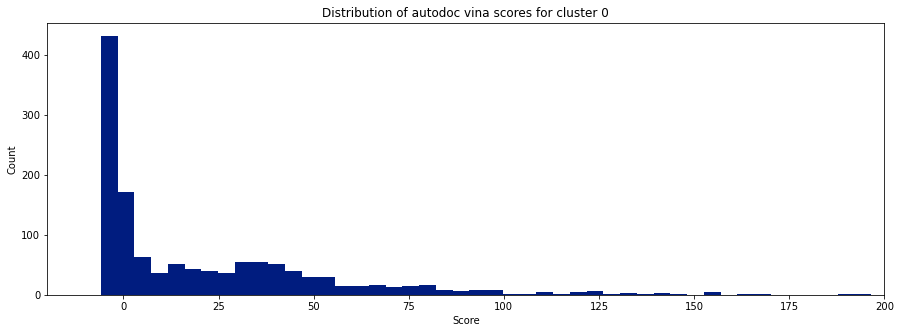

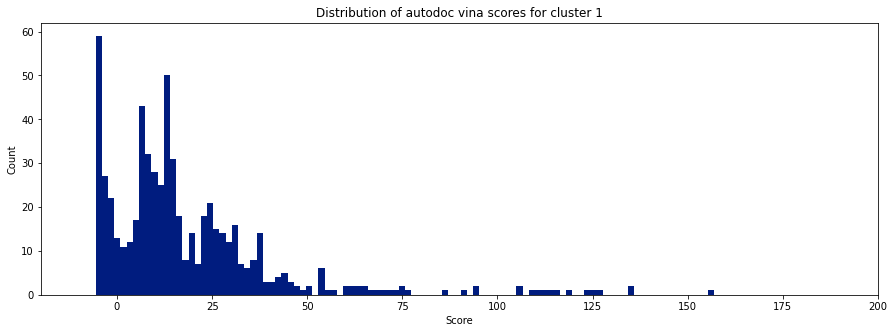

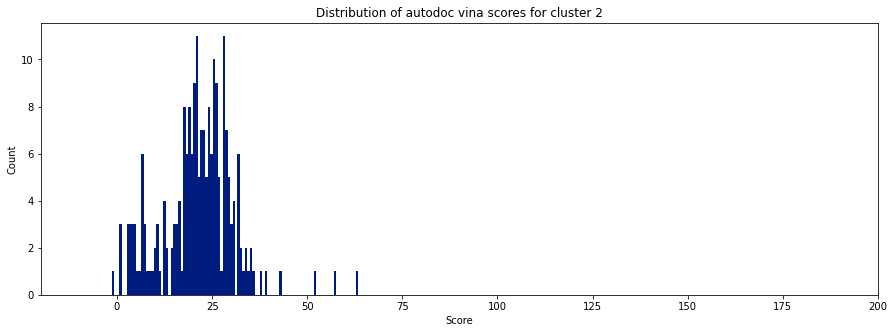

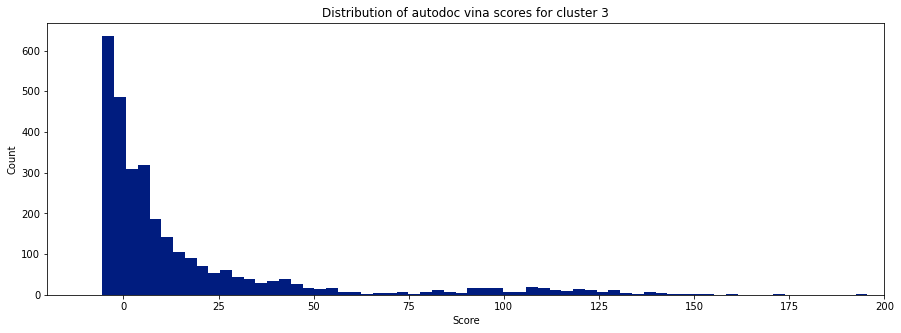

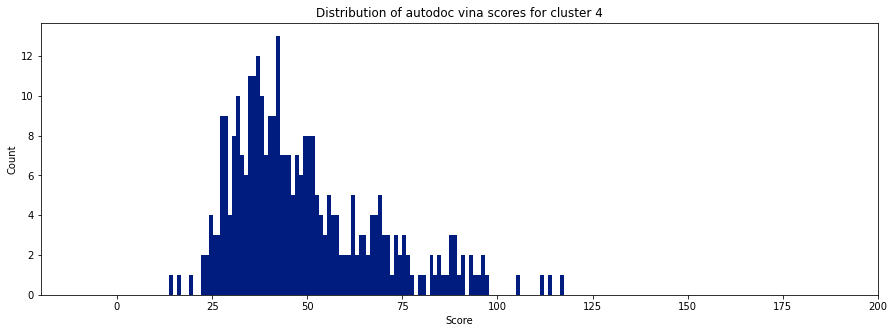

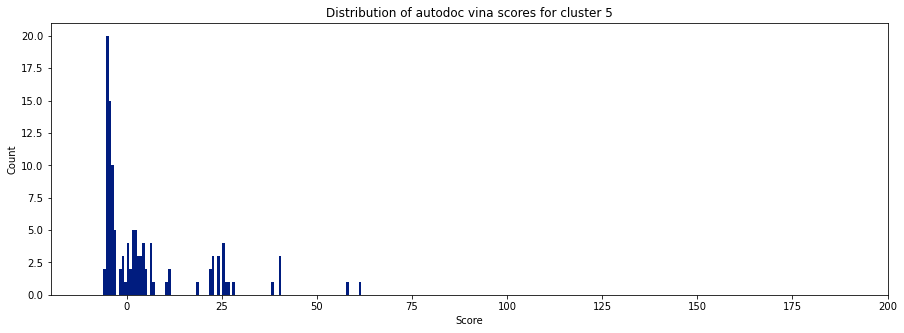

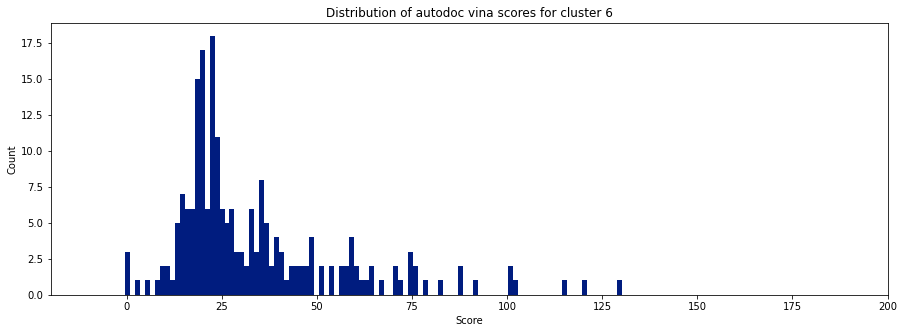

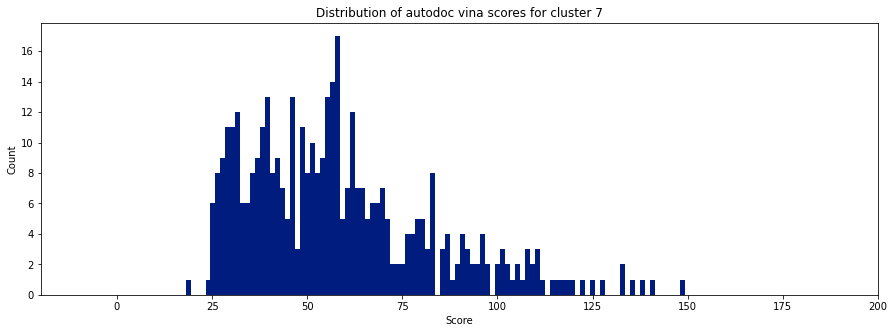

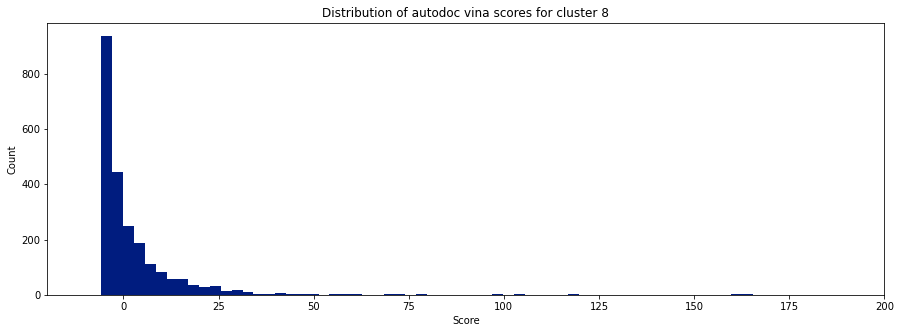

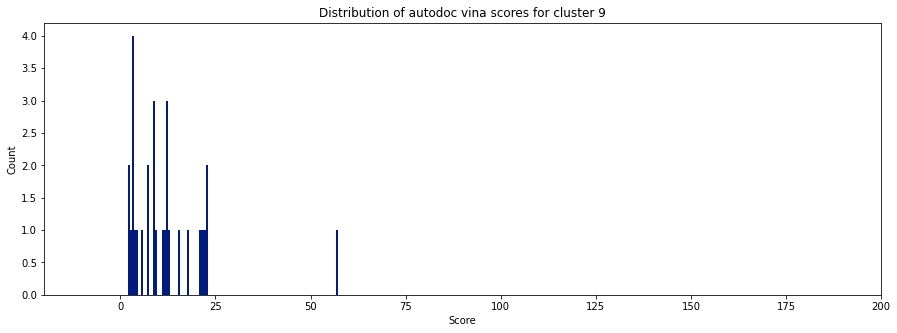

In [119]:
# Make q9 plotting function
def q9_plot(j):
    scores = []
    for m in og_id_cp[j].members:
        scores.append(id_score_map[m])
    plt.rcParams["figure.figsize"] = (15,5)
    plt.hist(scores, bins=100)
    plt.title("Distribution of autodoc vina scores for cluster " + str(j))
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.xlim(-20, 200)
    plt.savefig("part2_plots/q9_" + str(j) + ".png")
    plt.show()
    
# Generate plots
for j in range(10):
    q9_plot(j)
    
# Note: a few plots have outliers with scores between 200-500. I set
# the xlims from -20 to 200 because that illustrated the main
# distributional similarities/differences between cluster scores

Members of the same cluster seem to have similar docking scores. As discussed in class, structure is definitely related to function, but not necessarily always predictive of function. This clustering is based on structure. For some clusters (eg 0 and 8), it does appear to be more predictive of function - whichever structural similarities they share are probably important for docking. For others (4 and 7), the distribution is more spread out which could mean that their structural similarities are not so important for docking.

### Question 10

In [115]:
# Select top scoring molecule from each cluster
cluster_heads = {}
for j in range(len(og_id_cp)):
    chead = -1
    chead_score = np.inf
    for m in og_id_cp[j].members:
        if id_score_map[m] < chead_score:
            chead = m
            chead_score = id_score_map[m]
    cluster_heads[j] = (chead, chead_score)
print(cluster_heads)

{0: (740, -5.9), 1: (755, -5.6), 2: (2241, -1.4), 3: (1267, -5.5), 4: (4970, 13.7), 5: (2019, -6.1), 6: (2570, -0.4), 7: (5941, 18.0), 8: (883, -5.8), 9: (5174, 2.0)}


Top 5 (id, score, cluster):
1. 2019, -6.1, 5
2. 740, -5.9, 0
3. 883, -5.8, 8
4. 755, -5.6, 1
5. 1267, -5.5, 3

Screenshots from the top pymol exploration are in part2_plots/question_10/.

My favorite cluster head is 2019 because it kind of looks like a snail (see associated pic). The RMSD for 2019 aligned to the other 4 cluster heads are: 2.473 for 740, 2.441 for 883, 2.525 for 755, and 2.107 for 1267. All 4 of these RMSDs are more than 2 angstroms, which is somewhat high. Also, when visualizing the molecules in pymol, the structures look fairly different. Therefore, I think that they are structurally diverse.